In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
import os
import random
import time
import gc
from IPython.display import Markdown, display
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
#from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout,SeparableConv2D, Activation, BatchNormalization, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

def printmd(string):   
    display(Markdown(string))
    
np.random.seed(0) # Add random seed of training for reproducibility

def load_images_from_folder(folder,only_path = False, label = ""):
    if only_path == False:
        images = []
        for filename in os.listdir(folder):
            img = plt.imread(os.path.join(folder,filename))
            if img is not None:
                images.append(img)
        return images
    else:
        path = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder,filename)
            if img_path is not None:
                path.append([label,img_path])
        return path

In [ ]:
images = []
dirp = "/kaggle/input/fruit-recognition/"
for f in os.listdir(dirp):
    if "png" in os.listdir(dirp+f)[0]:
        images += load_images_from_folder(dirp+f,True,label = f)
    else: 
        for d in os.listdir(dirp+f):
            images += load_images_from_folder(dirp+f+"/"+d,True,label = f)
print(images)          
df = pd.DataFrame(images, columns = ["fruit", "path"])

from sklearn.utils import shuffle
df = shuffle(df, random_state = 0)
df = df.reset_index(drop=True)

fruit_names = sorted(df.fruit.unique())
mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
df["label"] = df["fruit"].map(mapper_fruit_names)
print(mapper_fruit_names)

df

In [4]:
df

,fruit,path,label
0,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
1,Pomegranate,/kaggle/input/fruit-recognition/Pomegranate/Po...,12
2,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
3,Mango,/kaggle/input/fruit-recognition/Mango/Mango003...,5
4,Guava,/kaggle/input/fruit-recognition/Guava/Guava to...,3
...,...,...,...
70544,Guava,/kaggle/input/fruit-recognition/Guava/guava B/...,3
70545,Kiwi,/kaggle/input/fruit-recognition/Kiwi/Total Num...,4
70546,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4
70547,Kiwi,/kaggle/input/fruit-recognition/Kiwi/kiwi A/Ki...,4


In [5]:
min_count = df['fruit'].value_counts().min()
print(min_count)

2072


In [7]:
balanced_df = df.groupby('fruit').apply(lambda x: x.sample(n=min_count)).reset_index(drop=True)
df = balanced_df

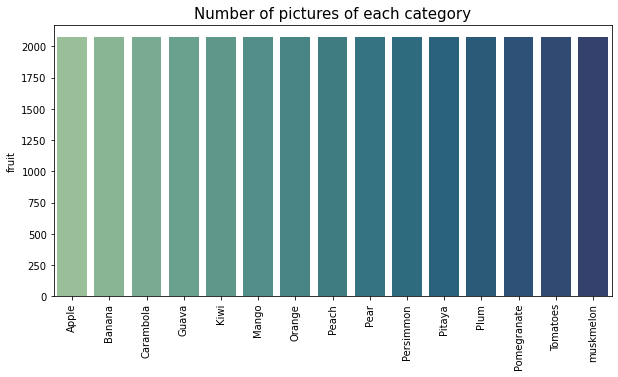

In [8]:
fc = df["fruit"].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(x = fc.index, y = fc, palette = "crest")

plt.title("Number of pictures of each category", fontsize = 15)
plt.xticks(rotation=90)
plt.show()

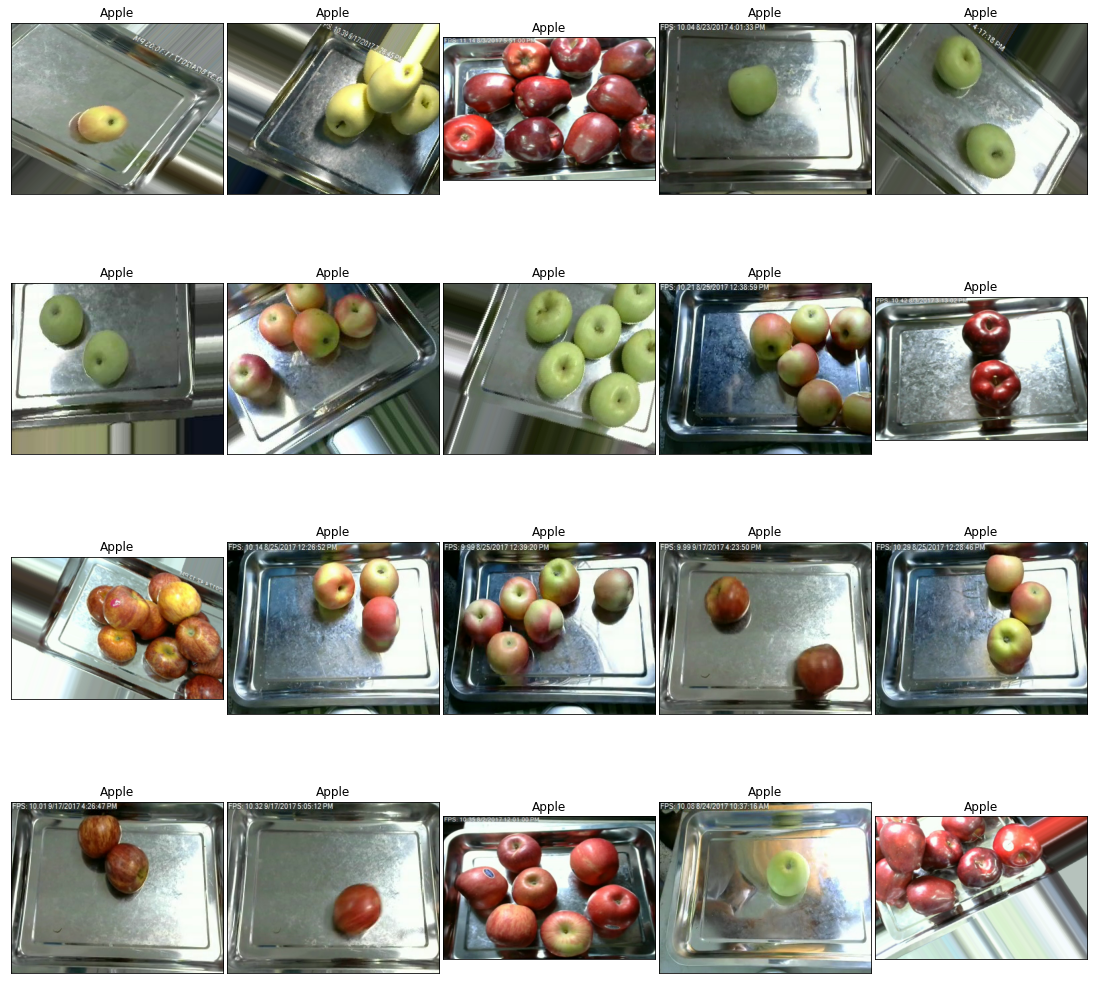

In [9]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.path[i+20]))
    ax.set_title(df.fruit[i+20], fontsize = 12)
plt.tight_layout(pad=0.0)
plt.show()

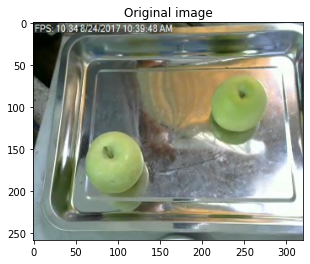

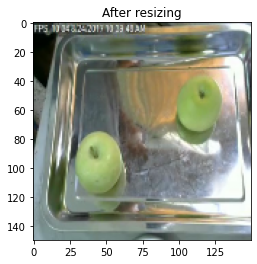

In [8]:
img = plt.imread(df.path[20])
plt.imshow(img)
plt.title("Original image")
plt.show()

plt.imshow(cv2.resize(img, (150,150)))
plt.title("After resizing")
plt.show()

In [10]:
print(df.shape[0])

31080


In [ ]:
def cut_df(df, number_of_parts, part):

    if part < 1:
        print("Error, the part should be at least 1")
    elif part > number_of_parts:
        print("Error, the part cannot be higher than the number_of_parts")
        
    number_imgs_each_part = int(df.shape[0]/number_of_parts)
    idx1 = (part-1) * number_imgs_each_part
    idx2 = part * number_imgs_each_part
    return df.iloc[idx1:idx2]


import numpy as np
import cv2
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def process_single_image(path, size=(150,150)):
    img = cv2.imread(path)  # Using cv2.imread instead of plt.imread
    return cv2.resize(img, size)

def load_img_optimized(df, num_workers=4):
   img_paths = df["path"].values
   img_labels = df["label"].values
   
   X = np.empty((len(img_paths), 150, 150, 3), dtype=np.float32)
   y = np.array(img_labels)
   
   with ThreadPoolExecutor(max_workers=num_workers) as executor:
       results = list(executor.map(process_single_image, img_paths))
   
   for i, img in enumerate(results):
       X[i] = img / 255.0  # Normalize to [0,1] range
       
   return X, y

In [12]:
inputShape = 150

In [19]:
def create_model():
    shape_img = (150,150,3)
    
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=shape_img, activation='relu', padding = 'same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(len(mapper_fruit_names)))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    
    return model

In [20]:
model = create_model()


In [22]:
print(model.layers[-1].get_config())

{'name': 'activation_1', 'trainable': True, 'dtype': 'float32', 'activation': 'softmax'}


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 64)        0

In [15]:
def from_categorical(lst):
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

def display_stats(y_test, pred):
    print(f"### Result of the predictions using {len(y_test)} test data ###\n")
    y_test_class = from_categorical(y_test)
    print("Classification Report:\n")
    print(classification_report(y_test_class, pred))
    print("\nConfusion Matrix:\n\n")
    print(confusion_matrix(y_test_class, pred))
    print("\n")
    printmd(f"# Accuracy: {round(accuracy_score(y_test_class, pred),5)}")
    
def plot_training(model):
    history = pd.DataFrame(model.history.history)
    history[["accuracy","val_accuracy"]].plot()
    plt.title("Training results")
    plt.xlabel("# epoch")
    plt.show()

In [16]:

mapper_fruit_names = dict(zip(fruit_names, [t for t in range(len(fruit_names))]))
print(mapper_fruit_names)

{'Apple': 0, 'Banana': 1, 'Carambola': 2, 'Guava': 3, 'Kiwi': 4, 'Mango': 5, 'Orange': 6, 'Peach': 7, 'Pear': 8, 'Persimmon': 9, 'Pitaya': 10, 'Plum': 11, 'Pomegranate': 12, 'Tomatoes': 13, 'muskmelon': 14}


In [29]:
hists = []
X_train, y_train = load_img_optimized(df)
y_train = to_categorical(y_train)



In [30]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks, validation_split = 0.2, verbose = 1)
hists.append(model.history.history)

In [ ]:
print(y_train.shape)
print(np.unique(y_train, return_counts=True))
print(X_train[:5])
print(y_train[:5])  # Should see one 1 and rest 0s per row

In [ ]:
# gc.collect()

In [ ]:
# time_model = time.time() - start_time
# print(f"Time to train the model: {int(time_model)} seconds")

In [ ]:
# acc = []
# val_acc = []
# for i in range(len(hists)):
#     acc += hists[i]["accuracy"]
#     val_acc += hists[i]["val_accuracy"]
# hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
# hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
# plt.title("Accuracy vs Validation Accuracy")
# plt.show()

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# X, y = load_img(cut_df(df, 20, 20))
# #pred = model.predict_classes(X)
# pred = np.argmax(model.predict(X), axis=1)
# y_test = to_categorical(y)

# display_stats(y_test, pred)

In [ ]:
# fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     ax.imshow(X[-i])
#     ax.set_title(f"True label: {fruit_names[y[-i]]}\nPredicted label: {fruit_names[pred[-i]]}")

# plt.tight_layout()
# plt.show()

**RESNET 50*** 

In [17]:
print(df)

           fruit                                               path  label
0          Apple  /kaggle/input/fruit-recognition/Apple/Apple B/...      0
1          Apple  /kaggle/input/fruit-recognition/Apple/Total Nu...      0
2          Apple  /kaggle/input/fruit-recognition/Apple/Total Nu...      0
3          Apple  /kaggle/input/fruit-recognition/Apple/Total Nu...      0
4          Apple  /kaggle/input/fruit-recognition/Apple/Apple A/...      0
...          ...                                                ...    ...
31075  muskmelon  /kaggle/input/fruit-recognition/muskmelon/Musk...     14
31076  muskmelon  /kaggle/input/fruit-recognition/muskmelon/Musk...     14
31077  muskmelon  /kaggle/input/fruit-recognition/muskmelon/Musk...     14
31078  muskmelon  /kaggle/input/fruit-recognition/muskmelon/Musk...     14
31079  muskmelon  /kaggle/input/fruit-recognition/muskmelon/Musk...     14

[31080 rows x 3 columns]


In [33]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50

In [32]:
IMAGE_SIZE_resnet = 150

In [34]:
resnet=ResNet50(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE_resnet,IMAGE_SIZE_resnet,3), pooling='max')
model_resnet=Sequential()
model_resnet.add(resnet)
model_resnet.add(Dense(256,activation='relu'))
model_resnet.add(Dense(100,activation='relu'))
model_resnet.add(Dense(15,activation='softmax'))
for layer in resnet.layers:
  layer.trainable = False

model_resnet.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model_resnet.summary()

94781440/94765736 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               25700     
_________________________________________________________________
dense_5 (Dense)              (None, 15)                1515      
Total params: 24,139,471
Trainable params: 551,759
Non-trainable params: 23,587,712
_________________________________________________________________


In [26]:
print("y_train shape:", y_train.shape)
print("Unique classes:", len(np.unique(np.argmax(y_train, axis=1))))

y_train shape: (31080, 15)
Unique classes: 15


In [36]:
# Fit the model
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=callbacks, validation_split = 0.2, verbose = 1)

Epoch 1/20
777/777 [==============================] - 348s 447ms/step - loss: 0.6615 - accuracy: 0.7878 - val_loss: 0.3436 - val_accuracy: 0.8895
Epoch 2/20
777/777 [==============================] - 350s 450ms/step - loss: 0.4600 - accuracy: 0.8530 - val_loss: 0.1956 - val_accuracy: 0.9355
Epoch 3/20
777/777 [==============================] - 348s 448ms/step - loss: 0.3745 - accuracy: 0.8836 - val_loss: 0.2161 - val_accuracy: 0.9279
Epoch 4/20
777/777 [==============================] - 353s 454ms/step - loss: 0.3398 - accuracy: 0.8939 - val_loss: 0.1939 - val_accuracy: 0.9447
Epoch 5/20
777/777 [==============================] - 357s 459ms/step - loss: 0.2885 - accuracy: 0.9103 - val_loss: 0.2064 - val_accuracy: 0.9321
Epoch 6/20
777/777 [==============================] - 353s 454ms/step - loss: 0.2858 - accuracy: 0.9128 - val_loss: 0.1404 - val_accuracy: 0.9554
Epoch 7/20
777/777 [==============================] - 354s 455ms/step - loss: 0.2553 - accuracy: 0.9217 - val_loss: 0.1675 -

In [40]:
history_resnet = []

In [41]:
history_resnet.append(model.history.history)

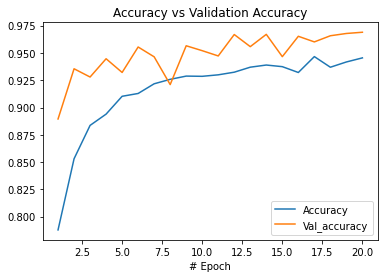

In [44]:
acc = []
val_acc = []
for i in range(len(history_resnet)):
    acc += history_resnet[i]["accuracy"]
    val_acc += history_resnet[i]["val_accuracy"]
hist_df = pd.DataFrame({"# Epoch": [e for e in range(1,len(acc)+1)],"Accuracy": acc, "Val_accuracy": val_acc})
hist_df.plot(x = "# Epoch", y = ["Accuracy","Val_accuracy"])
plt.title("Accuracy vs Validation Accuracy")
plt.show()